# Air Quality

Dataset: https://archive.ics.uci.edu/dataset/360/air+quality

### Description of features:

1. Date	(DD/MM/YYYY)
2. Time	(HH.MM.SS)
3. CO(GT): True hourly averaged concentration CO in mg/m^3  (reference analyzer)
4. PT08.S1 (tin oxide)  hourly averaged sensor response (nominally  CO targeted)	
5. True hourly averaged overall Non Metanic HydroCarbons concentration in microg/m^3 (reference analyzer)
6. True hourly averaged Benzene concentration  in microg/m^3 (reference analyzer)
7. PT08.S2 (titania) hourly averaged sensor response (nominally NMHC targeted)	
8. True hourly averaged NOx concentration  in ppb (reference analyzer)
9. PT08.S3 (tungsten oxide) hourly averaged sensor response (nominally NOx targeted) 
10. True hourly averaged NO2 concentration in microg/m^3 (reference analyzer)	
11. PT08.S4 (tungsten oxide) hourly averaged sensor response (nominally NO2 targeted)	
12. PT08.S5 (indium oxide) hourly averaged sensor response (nominally O3 targeted)
13. Temperature in Â°C	
14. Relative Humidity (%) 	
15. AH Absolute Humidity

Unneccesary features: Date, Time

Input Variables: PT08.S1(CO), NMHC(GT), C6H6(GT), PT08.S2(NMHC), NOx(GT), PT08.S3(NOx), NO2(GT), PT08.S4(NO2), PT08.S5(O3), T, RH, AH

Output Variable: CO(GT)

In [181]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, confusion_matrix, mean_absolute_error
from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE, SelectKBest, f_classif, f_regression

In [182]:
data = pd.read_csv("./data/AirQualityUCI.csv", sep=";", decimal=",")
data.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Unnamed: 15,Unnamed: 16
0,10/03/2004,18.00.00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578,NaN,NaN
1,10/03/2004,19.00.00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255,NaN,NaN
2,10/03/2004,20.00.00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502,NaN,NaN
3,10/03/2004,21.00.00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867,NaN,NaN
4,10/03/2004,22.00.00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888,NaN,NaN


### Data Pre-Processing

In [183]:
# Remove last 2 NaN columns
data = data.iloc[:, :-2]

# Convert all to numeric
data = data.apply(pd.to_numeric, errors="coerce")

# Convert -200 to NaN for easier processing
data.replace(-200, pd.NA, inplace=True)

# Drop rows where CO is NaN (this is the target)
data = data.dropna(subset=["CO(GT)"])

# Fill remaining missing values with mean of col
data = data.fillna(data.mean())

# Get rid of date / time - not needed
data = data.drop(["Date", "Time"], axis=1)

/var/folders/1g/jcrgh75n7m716qrsm7myd_j40000gn/T/ipykernel_51733/2942659616.py:14: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data = data.fillna(data.mean())


In [184]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7674 entries, 0 to 9356
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   CO(GT)         7674 non-null   float64
 1   PT08.S1(CO)    7674 non-null   float64
 2   NMHC(GT)       7674 non-null   float64
 3   C6H6(GT)       7674 non-null   float64
 4   PT08.S2(NMHC)  7674 non-null   float64
 5   NOx(GT)        7674 non-null   float64
 6   PT08.S3(NOx)   7674 non-null   float64
 7   NO2(GT)        7674 non-null   float64
 8   PT08.S4(NO2)   7674 non-null   float64
 9   PT08.S5(O3)    7674 non-null   float64
 10  T              7674 non-null   float64
 11  RH             7674 non-null   float64
 12  AH             7674 non-null   float64
dtypes: float64(13)
memory usage: 839.3 KB


In [185]:
data.describe()

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
count,7674.000000,7674.000000,7674.000000,7674.000000,7674.000000,7674.000000,7674.000000,7674.000000,7674.000000,7674.000000,7674.000000,7674.000000,7674.000000
mean,2.152750,1110.580746,223.641573,10.275735,947.198121,255.313869,826.920071,114.811932,1444.752723,1043.512936,17.770425,49.060076,0.989453
std,1.453252,213.927135,69.782848,7.279297,259.700177,209.472100,251.068817,46.918066,342.727584,396.752410,8.670011,17.072161,0.391195
min,0.100000,647.000000,7.000000,0.200000,387.000000,2.000000,322.000000,2.000000,551.000000,221.000000,-1.900000,9.200000,0.184700
25%,1.100000,953.000000,223.641573,4.800000,752.000000,107.000000,657.000000,82.000000,1215.250000,759.000000,11.500000,36.200000,0.714375
50%,1.800000,1087.000000,223.641573,8.900000,934.000000,201.000000,807.000000,114.000000,1444.752723,1013.000000,17.550000,49.060076,0.983950
75%,2.900000,1235.000000,223.641573,14.000000,1116.750000,326.000000,949.000000,141.000000,1659.000000,1287.000000,23.500000,61.800000,1.235200
max,11.900000,2040.000000,1189.000000,63.700000,2214.000000,1479.000000,2683.000000,340.000000,2775.000000,2523.000000,44.600000,88.700000,2.180600


CO(GT)              Axes(0.125,0.798085;0.168478x0.0819149)
PT08.S1(CO)      Axes(0.327174,0.798085;0.168478x0.0819149)
NMHC(GT)         Axes(0.529348,0.798085;0.168478x0.0819149)
C6H6(GT)         Axes(0.731522,0.798085;0.168478x0.0819149)
PT08.S2(NMHC)       Axes(0.125,0.699787;0.168478x0.0819149)
NOx(GT)          Axes(0.327174,0.699787;0.168478x0.0819149)
PT08.S3(NOx)     Axes(0.529348,0.699787;0.168478x0.0819149)
NO2(GT)          Axes(0.731522,0.699787;0.168478x0.0819149)
PT08.S4(NO2)        Axes(0.125,0.601489;0.168478x0.0819149)
PT08.S5(O3)      Axes(0.327174,0.601489;0.168478x0.0819149)
T                Axes(0.529348,0.601489;0.168478x0.0819149)
RH               Axes(0.731522,0.601489;0.168478x0.0819149)
AH                  Axes(0.125,0.503191;0.168478x0.0819149)
dtype: object

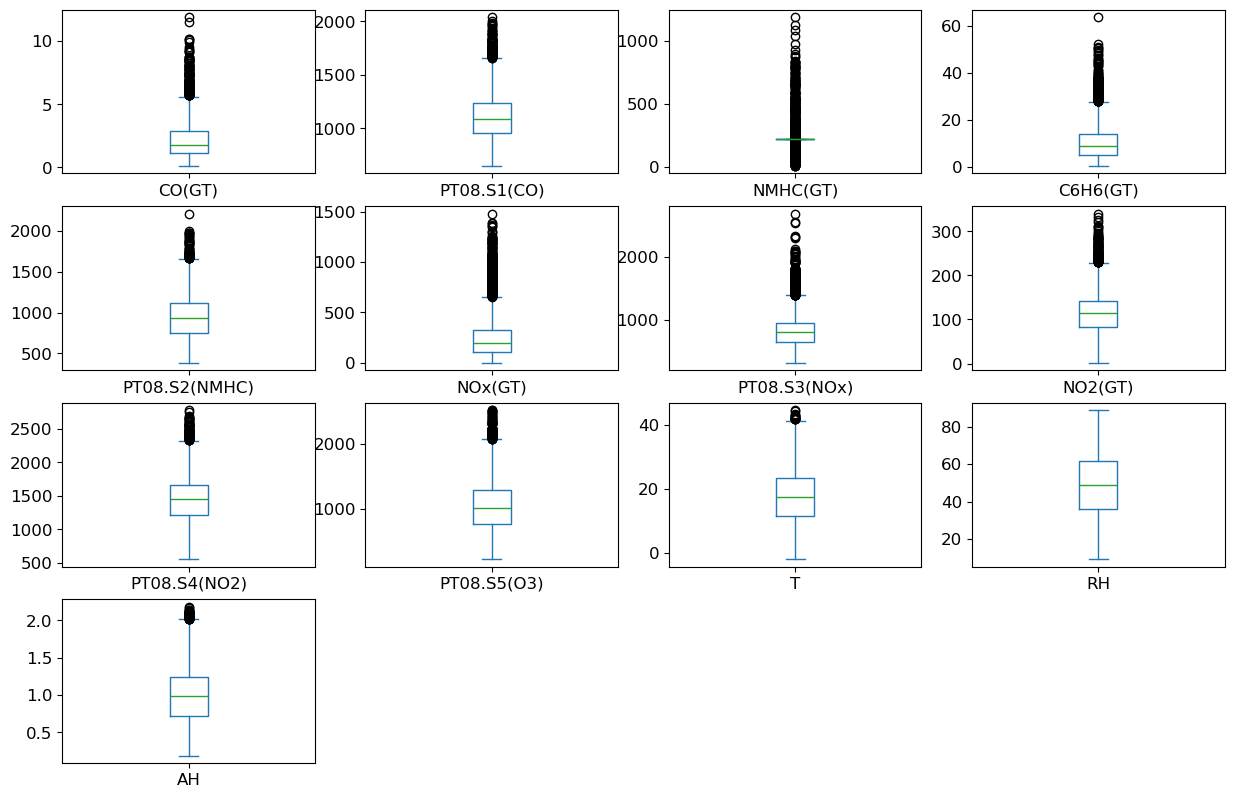

In [186]:
data_mean = data.iloc[:,:]
data_mean.plot(kind='box', subplots=True, layout=(8,4), sharex=False, sharey=False,fontsize=12, figsize=(15,20))

<Axes: >

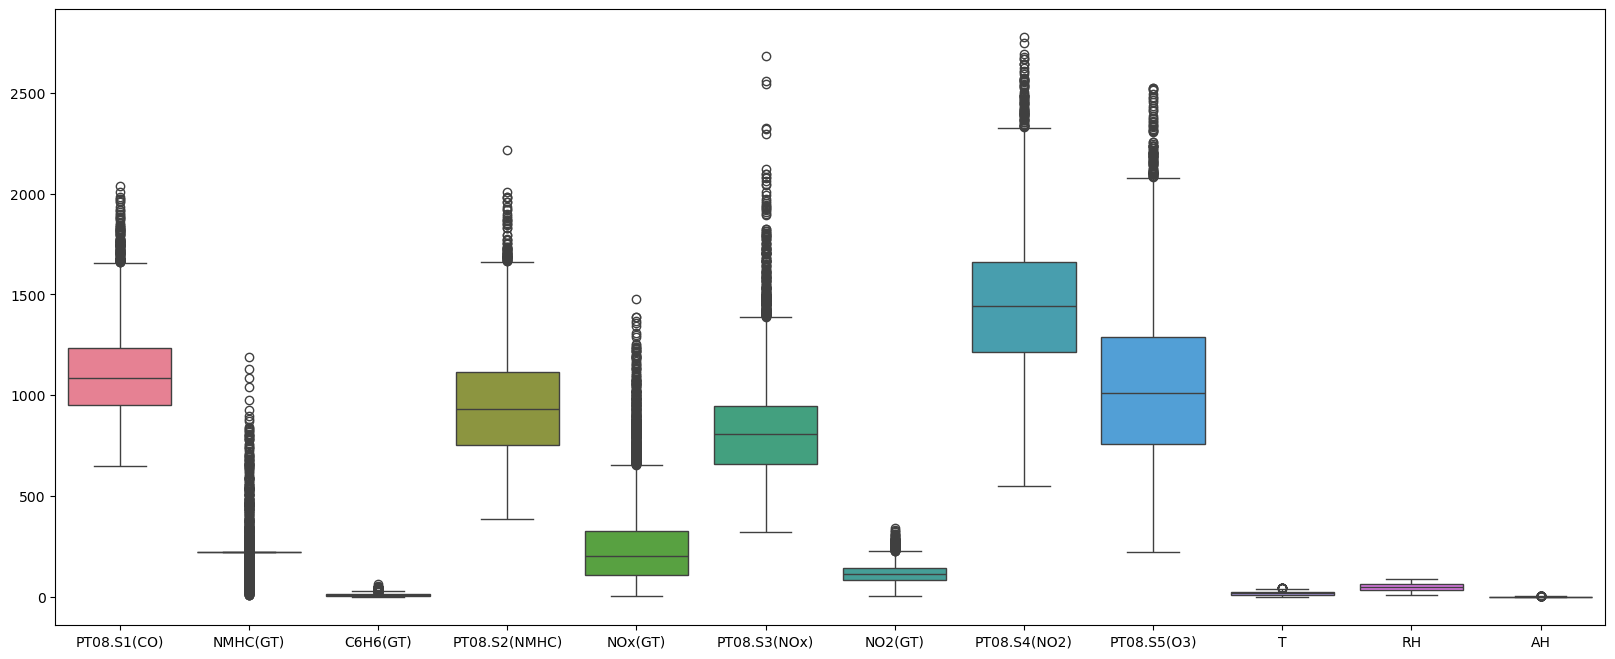

In [187]:
import seaborn as sns

fig,ax = plt.subplots(1,figsize=(20,8))
sns.boxplot(data=data.iloc[:,1:14])

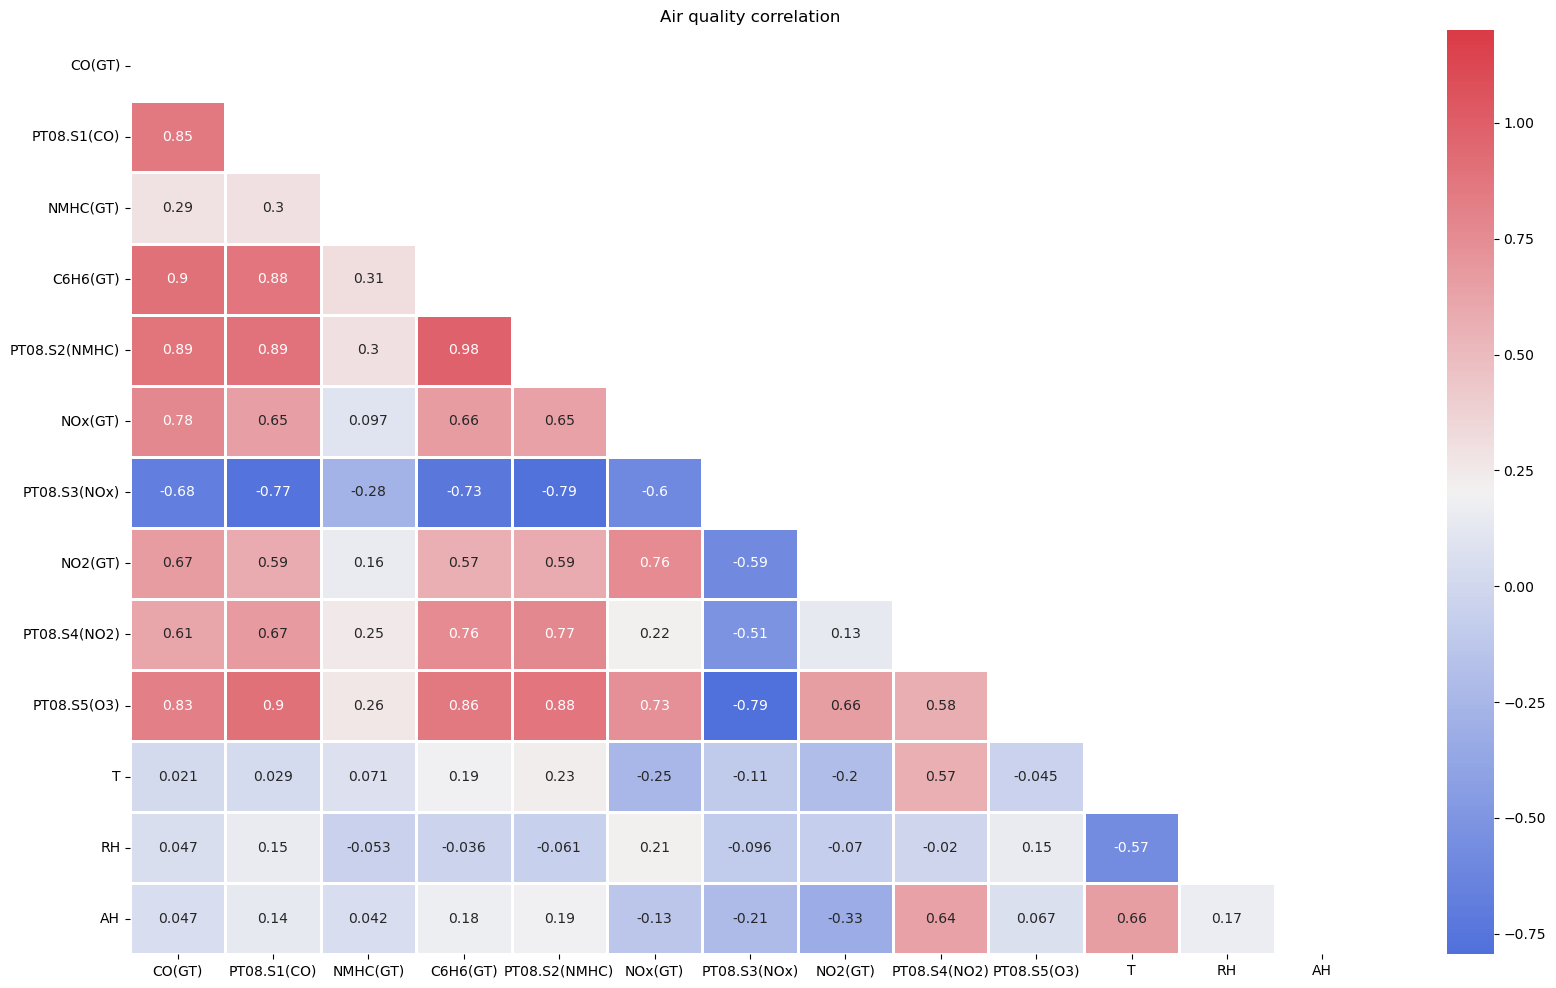

In [188]:
# Heatmap
correlationMatrix = data.corr(numeric_only=True)
mask = np.zeros_like(correlationMatrix)
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(figsize=(20, 12))
plt.title("Air quality correlation")
cmap = sns.diverging_palette(260, 10, as_cmap=True)
sns.heatmap(correlationMatrix, vmax=1.2, square=False, cmap=cmap, mask=mask, ax=ax, annot=True, fmt=".2g", linewidths=1)
plt.show()

### Linear Regression

In [189]:
# Define features and targets
x = data.drop("CO(GT)", axis=1)
y = data["CO(GT)"]

# Splitting data
# Training and test validation sets 70:30
x_train, x_test_val, y_train, y_test_val = train_test_split(x, y, test_size=0.3, random_state=42)

# Test validation --> validation and test sets 50:50
x_val, x_test, y_val, y_test = train_test_split(x_test_val, y_test_val, test_size=0.5, random_state=42)

<Axes: >

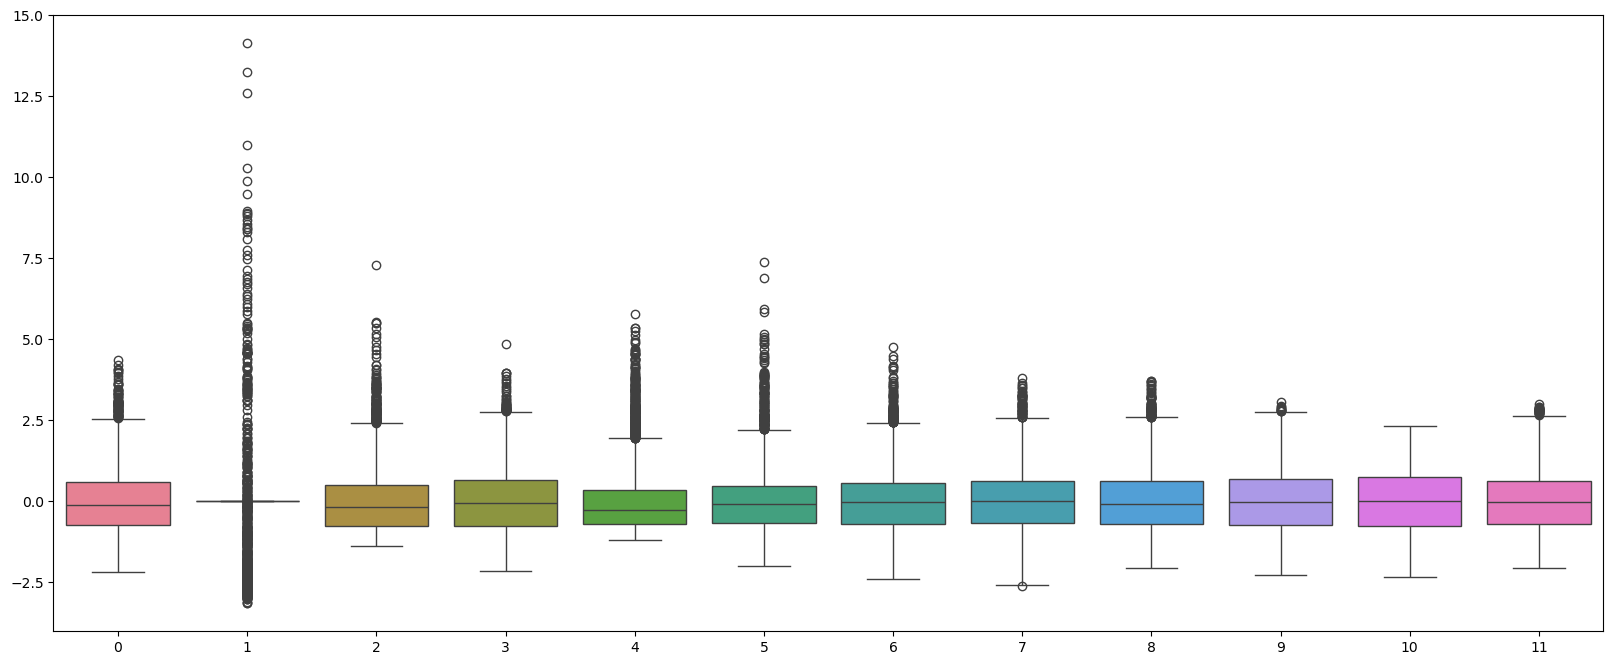

In [190]:
# Data scaling distributions
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)

fig, ax = plt.subplots(1, figsize=(20, 8))
sns.boxplot(data=x_train_scaled, ax=ax)

In [191]:
# Basic model
model = LinearRegression()
model.fit(x_train, y_train)

# Validate the model on the validation set
y_val_pred = model.predict(x_val)
val_mae = mean_absolute_error(y_val, y_val_pred)
val_mse = mean_squared_error(y_val, y_val_pred)
val_r2 = r2_score(y_val, y_val_pred)

print("Validation set performance (non-tuned):")
print(f"Validation MAE: {val_mae}")
print(f"Validation MSE: {val_mse}")
print(f"Validation R^2: {val_r2}")

# Evaluate the model on the test set
y_test_pred = model.predict(x_test)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("Test set performance (non-tuned):")
print(f"Model score: {model.score(x_test, y_test):03.2f}")
print(f"Test MAE: {test_mae:03.2f}")
print(f"Test MSE: {test_mse:03.2f}")
print(f"Test R^2: {test_r2:03.2f}")

Validation set performance (non-tuned):
Validation MAE: 0.31580128041230854
Validation MSE: 0.24794950714100453
Validation R^2: 0.8874436565929629
Test set performance (non-tuned):
Model score: 0.90
Test MAE: 0.29
Test MSE: 0.20
Test R^2: 0.90


In [192]:
# Define pipeline with scaling, feature selection, polynomial features and regularised linear regression
pipeline = Pipeline([
    ("scalar", StandardScaler()),
    ("poly", PolynomialFeatures(degree=2, include_bias=False)),
    ("model", Ridge(alpha=1, max_iter=10000))
])

In [193]:
pipeline.fit(x_train, y_train)

Pipeline(steps=[('scalar', StandardScaler()),
                ('poly', PolynomialFeatures(include_bias=False)),
                ('model', Ridge(alpha=1, max_iter=10000))])

In [194]:
# Evaluate best model on validation set
y_val_pred = pipeline.predict(x_test)

val_mae = mean_absolute_error(y_test, y_val_pred)
val_mse = mean_squared_error(y_test, y_val_pred)
val_rsqd = r2_score(y_test, y_val_pred)

print("Test Set Performance (tuned):")
print(f"Model score: {pipeline.score(x_test, y_test):03.2f}")
print(f"Test MAE: {val_mae:03.2f}")
print(f"Test MSE: {val_mse:03.2f}")
print(f"Test R^2: {val_rsqd:03.2f}")

Test Set Performance (tuned):
Model score: 0.92
Test MAE: 0.27
Test MSE: 0.17
Test R^2: 0.92


In [195]:
# Evaluate best model on test set
y_test_pred = pipeline.predict(x_test)

test_mae = mean_absolute_error(y_test, y_test_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
test_rsqd = r2_score(y_test, y_test_pred)

print("Test Set Performance (tuned):")
print(f"Model score: {pipeline.score(x_test, y_test):03.2f}")
print(f"Test MAE: {test_mae:03.2f}")
print(f"Test MSE: {test_mse:03.2f}")
print(f"Test R^2: {test_rsqd:03.2f}")

Test Set Performance (tuned):
Model score: 0.92
Test MAE: 0.27
Test MSE: 0.17
Test R^2: 0.92


In [196]:
cross_val_mse = cross_val_score(pipeline, x_train, y_train, cv=5, scoring="neg_mean_squared_error")
print(f"Cross-validation MSE (training set): {cross_val_mse}")

Cross-validation MSE (training set): [-0.22059807 -0.2288183  -0.1745948  -0.19012758 -0.17660872]


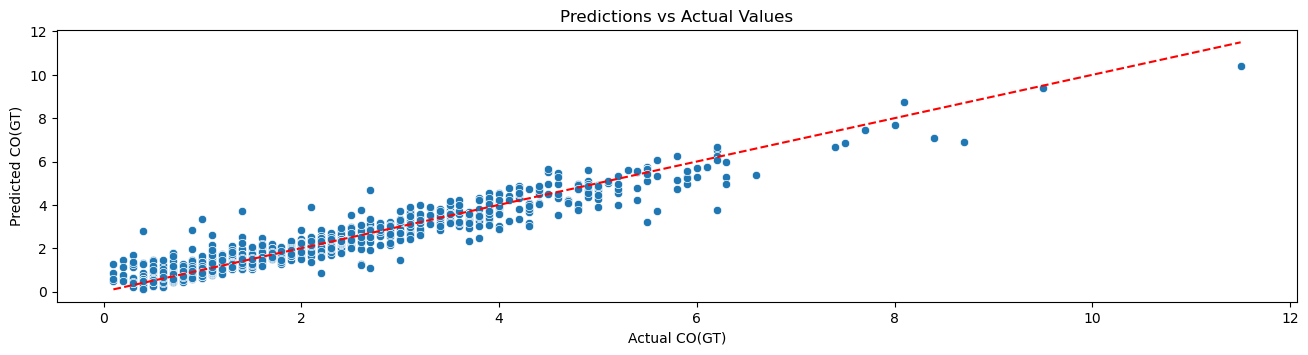

In [197]:
# Set up the visualizations
plt.figure(figsize=(16, 12))

# Scatter Plot of Predictions vs. Actual Values
plt.subplot(3, 1, 1)
sns.scatterplot(x=y_test, y=y_test_pred)
plt.xlabel('Actual CO(GT)')
plt.ylabel('Predicted CO(GT)')
plt.title('Predictions vs Actual Values')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')

Text(0.5, 1.0, 'Residuals vs Predicted Values')

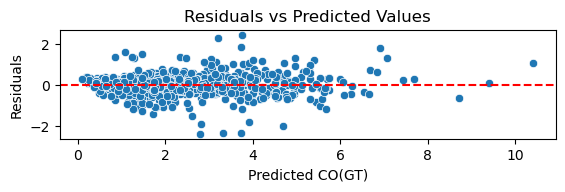

In [198]:
# Residuals Plot
plt.subplot(3, 1, 2)
residuals = y_test - y_test_pred
sns.scatterplot(x=y_test_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted CO(GT)')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')

Text(0.5, 1.0, 'Distribution of Prediction Errors')

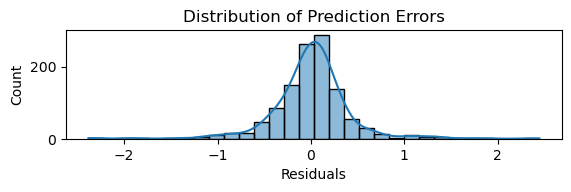

In [199]:
# Distribution of Errors
plt.subplot(3, 1, 3)
sns.histplot(residuals, bins=30, kde=True)
plt.xlabel('Residuals')
plt.title('Distribution of Prediction Errors')

### Support Vector Machine

<Axes: >

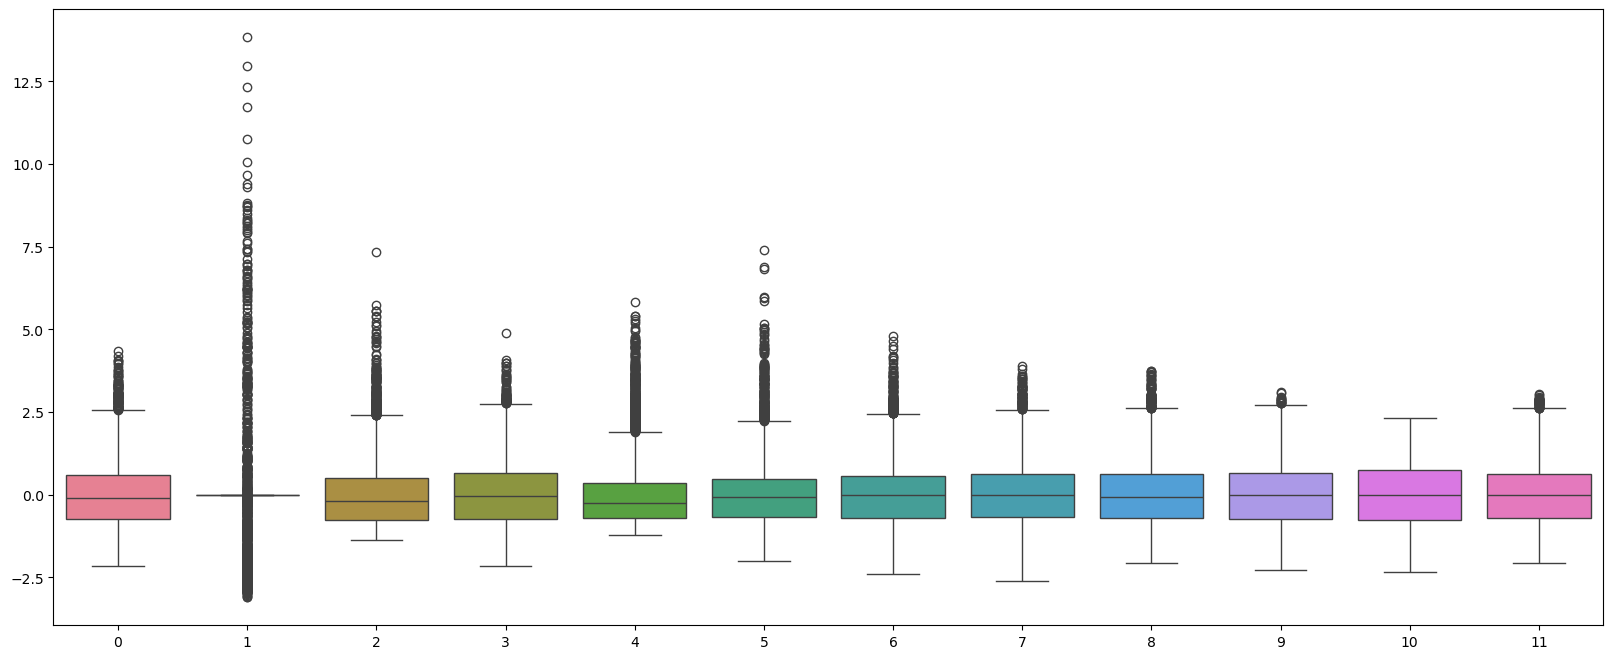

In [200]:
# Normalise features
y = data["CO(GT)"]
X = data.drop("CO(GT)",axis=1)

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
Xs = scaler.fit_transform(X)
fig, ax = plt.subplots(1, figsize=(20,8))
sns.boxplot(data = Xs, ax=ax)

In [201]:
# # Assign features to X
# y = X["CO(GT)"]
# X.drop('CO(GT)',axis=1)

In [202]:
# Splitting data
# Training and test validation sets 70:30
Xs_train, Xs_test, y_train, y_test = train_test_split(Xs, y, test_size=0.3, random_state=1)

In [203]:
from sklearn.svm import SVR

# Create and fit the SVR model
svm_regressor = SVR(C=1.0, kernel='rbf', degree=3, gamma='auto')
svm_regressor.fit(Xs_train, y_train)

# Evaluate the model using R^2 score
regressor_score = svm_regressor.score(Xs_test, y_test)
print(f"SVM R² Score: {regressor_score:.2f}")

SVM R² Score: 0.91


In [204]:
y_pred = svm_regressor.predict(Xs_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"SVM MSE: {mse:.2f}", )
print(f"SVM RMSE: {rmse:.2f}", )
print(f"SVM R² Score: {r2:.2f}")

MLP MSE: 0.19
MLP RMSE: 0.44
MLP R² Score: 0.91


### Decision Tree

Best Parameters: {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2}
Decision Tree R² Score on Validation Set: 0.87
Decision Tree R² Score on Test Set: 0.88


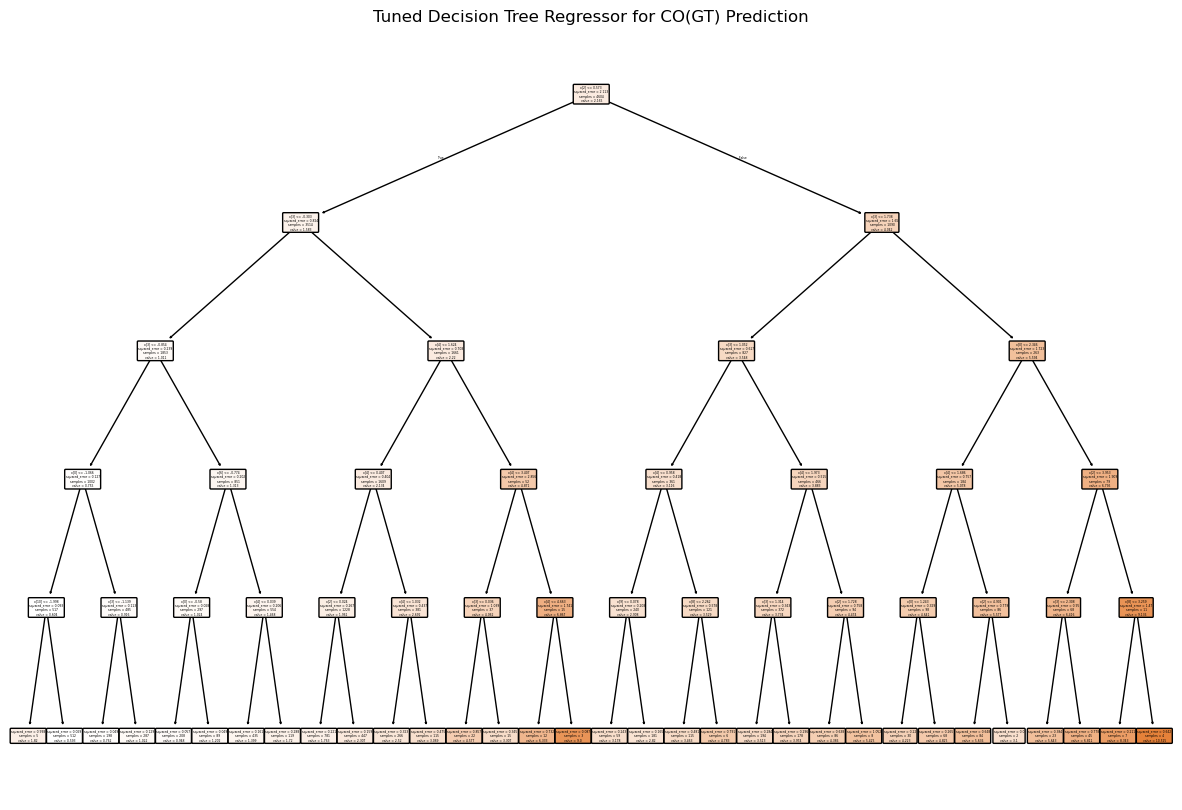

In [205]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Split data into training (60%) and temp (40%) sets
X_train, X_temp, y_train, y_temp = train_test_split(Xs, y, test_size=0.4, random_state=42)

# Split the temp set into validation (20%) and test (20%) sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Set up the parameter grid to tune max_depth, min_samples_split, and min_samples_leaf
param_grid = {
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 3]
}

# Initialise the DecisionTreeRegressor
tree_reg = DecisionTreeRegressor(random_state=42)

# Use GridSearchCV on the training set to find the best hyperparameters
grid_search = GridSearchCV(estimator=tree_reg, param_grid=param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(X_train, y_train)
print("Best Parameters:", grid_search.best_params_)

# Train a DecisionTreeRegressor with the best parameters on the training set
best_tree_reg = grid_search.best_estimator_
best_tree_reg.fit(X_train, y_train)

# Calculate the R² score on the validation set
val_regressor_score = best_tree_reg.score(X_val, y_val)
print(f'Decision Tree R² Score on Validation Set: {val_regressor_score:0.2f}')

# Calculate the R² score on the test set with the best model
test_regressor_score = best_tree_reg.score(X_test, y_test)
print(f'Decision Tree R² Score on Test Set: {test_regressor_score:.2f}')

# Plot the decision tree
plt.figure(figsize=(15, 10))
plot_tree(
    best_tree_reg, 
    filled=True, 
    feature_names=X_train.columns if hasattr(X_train, 'columns') else None,
    rounded=True
)
plt.title("Tuned Decision Tree Regressor for CO(GT) Prediction")
plt.show()


### Multi Layer Perceptron Neural Network

In [206]:
from sklearn.neural_network import MLPRegressor

X_train, X_test, y_train, y_test = train_test_split(Xs, y, test_size=0.3, random_state=0)

mlp_reg = MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=1000, learning_rate_init=0.001, early_stopping=True)
mlp_reg.fit(X_train, y_train)
y_pred = mlp_reg.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"MLP MSE: {mse:.2f}", )
print(f"MLP RMSE: {rmse:.2f}", )
print(f"MLP R² Score: {r2:.2f}")

MLP MSE: 0.18
MLP RMSE: 0.42
MLP R² Score: 0.91


### K-fold Cross-Validation

In [207]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVR, SVC
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, KFold, cross_val_score

In [208]:
# Initialize models for regression tasks
models_regression = {
    'Linear Regression': LinearRegression(),
    'SVM': SVR(),
    'Decision Tree': DecisionTreeRegressor(),
    'MLP': MLPRegressor(max_iter=1000, learning_rate_init=0.001, early_stopping=True)
}

# # Assuming 'datetime' is the column you want to drop
# if 'DateTime' in data.columns:
#     data.drop(columns=['DateTime'], inplace=True)

# Split data    
X_reg = Xs
y_reg = y

# Set up K-Fold cross-validation
k = 10
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# For each model, perform K-fold cross-validation and compute the average metric
for name, model in models_regression.items():
    pipeline = Pipeline([
        ('scaler', StandardScaler()),  # Scaling step
        ('model', model)               # Model step
    ])
    mse_scores = -cross_val_score(pipeline, X_reg, y_reg, cv=kf, scoring='neg_mean_squared_error')
    rmse_scores = np.sqrt(mse_scores)
    print(f'{name} - Average RMSE: {np.mean(rmse_scores):.2f}')


Linear Regression - Average RMSE: 0.49
SVM - Average RMSE: 0.42
Decision Tree - Average RMSE: 0.59
MLP - Average RMSE: 0.42
